# Double pendulum using Lagrange's equation

Defines a DoublePendulum class that creates plots of angle vs time for each plot, and checks if the system is chaotic, using Lagrange's equation.

* Last revised 26 April 2019 by Zoey Samples (samples.51@osu.edu)

## Euler-Lagrange equation

For a double pendulum, the Lagrangian with generalized coordinates $\phi_1$ and $\phi_2$ is

$\begin{align}
  \mathcal{L} = \frac{1}{2} (m_1 + m_2) L_1^2 \dot\phi_1 + m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \cos(\phi_1 - \phi_2) + \frac{1}{2} m_2 L_2^2 \dot\phi_2^2 -
  (m_1 + m_2) g L_1 (1 - \cos\phi_1) - m_2 g L_2 (1 - \cos\phi_2)
\end{align}$

The Euler-Lagrange equations we need to use are

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_1} = \frac{\partial\mathcal L}{\partial\phi_1}
\end{align}$

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_2} = \frac{\partial\mathcal L}{\partial\phi_2}
\end{align}$

Solving these equations, putting the double-dot terms on the left side, and grouping into matrix form yields the matrix equation

$$
\begin{bmatrix}
    m_2 L_1 L_2 \cos(\phi_1 - \phi_2) & m_2 L_2^2 \\
    (m_1 + m_2) L1^2 & m_2 L_1 L_2 \cos(\phi_1 - \phi_2)
\end{bmatrix}
\quad
\begin{bmatrix}
    \ddot\phi_1 \\
    \ddot\phi_2
\end{bmatrix}
=
\quad
\begin{bmatrix}
    m_2 L_1 L_2 \dot\phi_1^2 \sin(\phi_1 - \phi_2) - m_2 g L_2 \sin\phi_2 \\
    -m_2 L_1 L_2 \dot\phi_2^2 \sin(\phi_1 - \phi_2) - (m_1 + m_2) g L_1 \sin\phi_1
\end{bmatrix}
$$

We can isolate the double-dot column vector on the left side by multiplying both sides by the inverse of the first matrix

$$
\begin{bmatrix}
    \ddot\phi_1 \\
    \ddot\phi_2
\end{bmatrix}
=
k
\begin{bmatrix}
    -m_2 L_1 L_2 \cos(\phi_1 - \phi_2) & (m_1 + m_2) L1^2 \\
    m_2 L_2^2  & -m_2 L_1 L_2 \cos(\phi_1 - \phi_2)
\end{bmatrix}
\quad
\begin{bmatrix}
    m_2 L_1 L_2 \dot\phi_1^2 \sin(\phi_1 - \phi_2) - m_2 g L_2 \sin\phi_2 \\
    -m_2 L_1 L_2 \dot\phi_2^2 \sin(\phi_1 - \phi_2) - (m_1 + m_2) g L_1 \sin\phi_1
\end{bmatrix}
$$

where $k$ is $1$ over the determinant of the matrix, given by

$\begin{align}
k = \frac{1}{m_2^2 L_1^2 L_2^2 \cos^2(\phi_1 - \phi_2) - m_2 (m_1 + m_2) L_1^2 L_2^2}
\end{align}$

In [207]:
%matplotlib inline

In [208]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [209]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Double Pendulum class and functions

In [210]:
class DoublePendulum():
    
    """
    Double Pendulum class creates a double pendulum object for given parameters. This class
     assumes there is no driving or damping.
     
    Parameters
    ----------
    L_1 : float
        length of the first pendulum
    L_1 : float
        length of the second pendulum
    g : float
        acceleration of gravity
    mass_1 : float
        mass of the first pendulum
    mass_2 : float
        mass of the second pendulum

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
        
    """
    
    def __init__(self, L_1=1., L_2=1., mass_1=1., mass_2=1., g=1.):
        
        self.L_1 = L_1
        self.L_2 = L_2
        self.g = g
        self.mass_1 = mass_1
        self.mass_2 = mass_2
    
    def dy_dt(self, t, y):
        
        """
        This function returns the right-hand side of the diffeq: 
        [dphi_1/dt d^2phi_1/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi_1(t),
                                      y[1] = phi_2(t),
                                      y[2] = d/dt[phi_1(t)],
                                      y[3] = d/dt[phi_2(t)].
            
        Returns the values of phi_1_dot, phi_2_dot, phi_1_ddot, phi_2_ddot. The
        last 2 are given by the right hand side of the matrix equation above.
        
        """
        
        # Define the class variables as shorter variables to make our life easier.
        
        m1 = self.mass_1
        m2 = self.mass_2
        L1 = self.L_1
        L2 = self.L_2
        g = self.g
        phi12 = y[0] - y[1]
        
        # Initialize the right-hand-side of the matrix equation.
        
        k = 1./((m2**2)*(L1**2)*(L2**2)*(np.cos(phi12)**2) - m2*(m1 + m2)*(L1**2)*(L2**2))
            
        rh_matrix = np.zeros(4)
        rh_vector = np.zeros(2)
        
        rh_matrix[0] = -m2*L1*L2*np.cos(phi12)
        rh_matrix[1] = (m1 + m2)*(L1**2)
        rh_matrix[2] = m2*(L2**2)
        rh_matrix[3] = -m2*L1*L2*np.cos(phi12)
        
        rh_vector[0] = m2*L1*L2*(y[2]**2)*np.sin(phi12) - m2*g*L2*np.sin(y[1])
        rh_vector[1] = -m2*L1*L2*(y[3]**2)*np.sin(phi12) - (m1 + m2)*g*L1*np.sin(y[0])
        
        phi_1_ddot = k*(rh_matrix[0]*rh_vector[0] + rh_matrix[1]*rh_vector[1])
        phi_2_ddot = k*(rh_matrix[2]*rh_vector[0] + rh_matrix[3]*rh_vector[1])
        
        return [y[2], y[3], phi_1_ddot, phi_2_ddot]
    
    def solve_ode(self, t_pts, phi_1_0, phi_2_0, phi_1_dot_0, phi_2_dot_0,
                  abserr=1.0e-9, relerr=1.0e-9):
        
        """
        Solves the ode and returns phi_1, phi_2, phi_1_dot, phi_2_dot
        from the initial conditions.
        
        Parameters
        ----------
        t : float
            time 
        phi_1_0 : float
            The initial value for phi_1
        phi_2_0 : float
            The initial value for phi_2
        phi_1_dot_0 : float
            The initial value for phi_1_dot
        phi_2_dot_0 : float
            The initial value for phi_2_dot
                                      
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        
        y = [phi_1_0, phi_2_0, phi_1_dot_0, phi_2_dot_0]
        
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_2, phi_1_dot, phi_2_dot = solution.y

        return phi_1, phi_2, phi_1_dot, phi_2_dot

In [211]:
def plot_y_vs_x(x, y1, y2, axis_labels=None, label=None, title=None, 
                color1=None, color2=None, linestyle=None, semilogy=False,
                loglog=False, ax=None):
    
    """
    Generic plotting function: return a figure axis with a plot of y1 vs. x
    and y2 vs. x, with line colors and style, title, axis labels, and line label.
    """
    
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y1, label=label, 
                            color=color1, linestyle=linestyle)
        line, = ax.semilogy(x, y2, label=label, 
                            color=color2, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y1, label=label, 
                          color=color1, linestyle=linestyle)
        line, = ax.loglog(x, y2, label=label, 
                          color=color2, linestyle=linestyle)
    else:
        line, = ax.plot(x, y1, label=label, 
                    color=color1, linestyle=linestyle)
        line, = ax.plot(x, y2, label=label, 
                    color=color2, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [212]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple pendulum plots 

In [213]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
state_space_labels = (r'$\phi$', r'$d\phi/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L_1 = 2.
L_2 = 1.
g = 1.
mass_1 = 1.
mass_2 = 1.

# Instantiate a pendulum 
p1 = DoublePendulum(L_1=L_1, L_2=L_2, mass_1=mass_1, mass_2=mass_2, g=g)


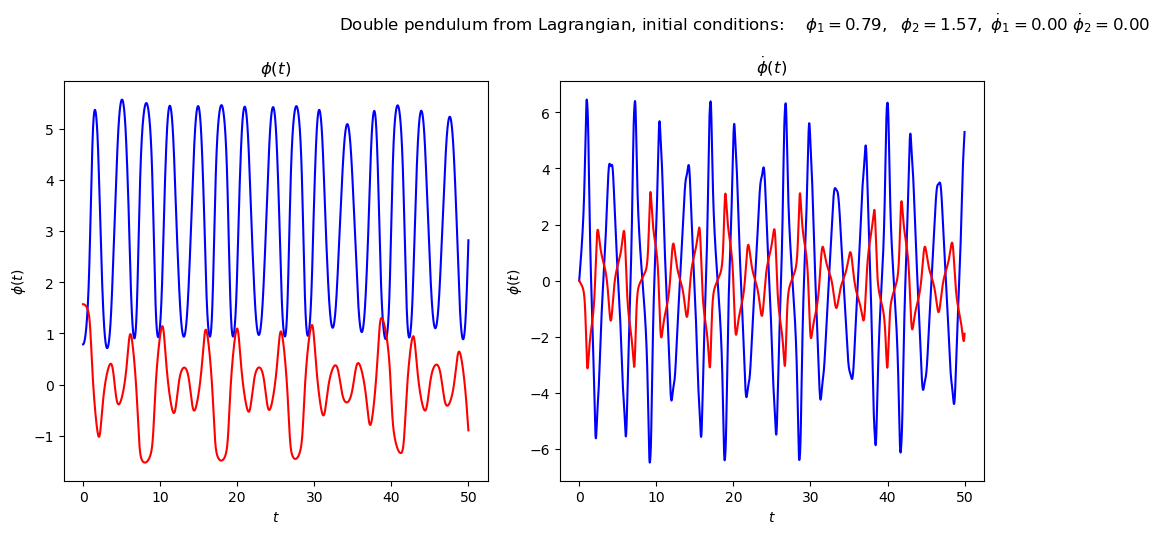

In [214]:
# Initial conditions
phi_1_0 = (1./4.)*np.pi
phi_2_0 = (1./2.)*np.pi
phi_1_dot_0 = 0.
phi_2_dot_0 = 0.

phi_1, phi_2, phi_1_dot, phi_2_dot = p1.solve_ode(
                                    t_pts, phi_1_0, phi_2_0,
                                    phi_1_dot_0, phi_2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian, initial conditions:  ' + \
                rf'  $\phi_1 = {phi_1_0:.2f},$' + \
                rf'  $\phi_2 = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_1 = {phi_1_dot_0:.2f}$' + \
                rf' $\dot\phi_2 = {phi_2_dot_0:.2f}$' + \
                '\n'
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], phi_2[start : stop],
            axis_labels=phi_vs_time_labels, 
            color1='blue',
            color2='red',
            label=None, 
            title=r'$\phi(t)$', 
            ax=ax_a)    
                              
# second plot: phi_dot plot 
ax_b = fig.add_subplot(1,3,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1_dot[start : stop], phi_2_dot[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color1='blue',
            color2='red',
            label=None, 
            title=r'$\dot\phi(t)$', 
            ax=ax_b)    

fig.tight_layout()
fig.savefig('simple_pendulum_Lagrange.png', bbox_inches='tight')  

There is an issue with this plot. The top pendulum $\phi_1$ is oscillating about the angle $\phi=\pi$, which is the upward vertical axis. This is clearly not allowed since gravity pulls downward, so the lowest potential is found vertically downward, at $\phi=0$. I am unsure where the error is, so I will leave it like this--however, understand that this plot is incorrect.

Test if the system is chaotic by changing the initial conditions by a very small amount and plotting the difference.

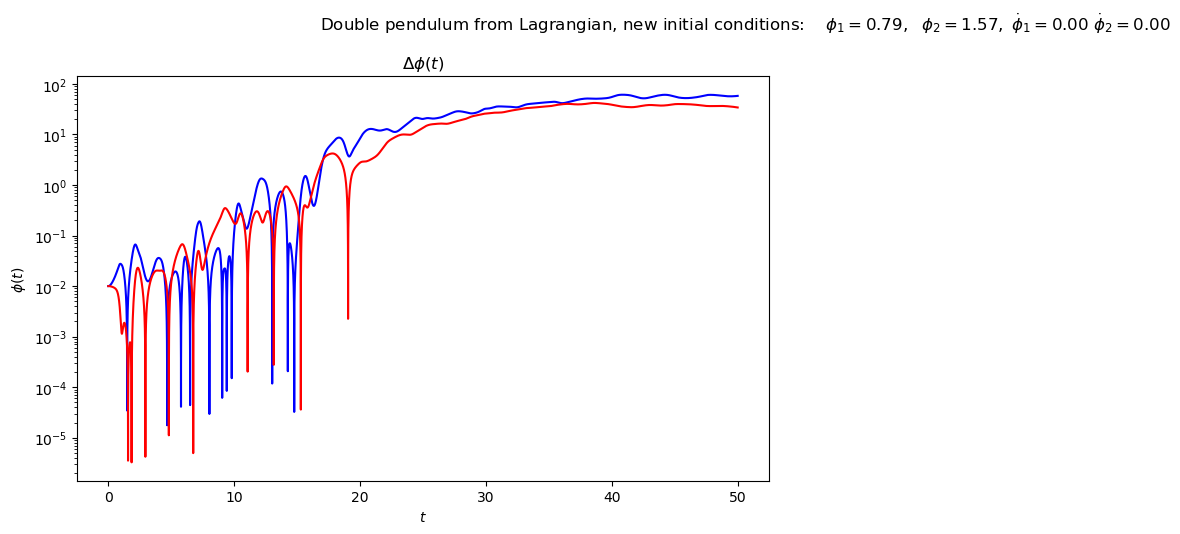

In [215]:
# Slightly adjusted initial conditions
d_phi = 0.01
phi_1_0_new = phi_1_0 + d_phi
phi_2_0_new = phi_2_0 + d_phi
phi_1_dot_0_new = phi_1_dot_0
phi_2_dot_0_new = phi_2_dot_0

phi_1_new, phi_2_new, phi_1_dot_new, phi_2_dot_new = p1.solve_ode(
                                    t_pts, phi_1_0_new, phi_2_0_new,
                                    phi_1_dot_0_new, phi_2_dot_0_new)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian, new initial conditions:  ' + \
                rf'  $\phi_1 = {phi_1_0:.2f},$' + \
                rf'  $\phi_2 = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_1 = {phi_1_dot_0:.2f}$' + \
                rf' $\dot\phi_2 = {phi_2_dot_0:.2f}$' + \
                '\n'
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,2,1)                  

delta_phi_1 = np.abs(phi_1_new - phi_1)
delta_phi_2 = np.abs(phi_2_new - phi_2)
delta_phi_1_dot = np.abs(phi_1_dot_new - phi_1_dot)
delta_phi_2_dot = np.abs(phi_2_dot_new - phi_2_dot)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], delta_phi_1[start : stop], delta_phi_2[start : stop],
            axis_labels=phi_vs_time_labels, 
            color1='blue',
            color2='red',
            label=None, 
            semilogy=True,
            title=r'$\Delta\phi(t)$', 
            ax=ax_a)
                              
fig.tight_layout()
fig.savefig('simple_pendulum_Lagrange.png', bbox_inches='tight')  

Because the $\Delta\phi$ plot increases steadily over time (i.e. the double pendulum's motion does not converge to some attractor), the motion of the double pendulum is chaotic.